In [1]:
import pandas as pd
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from scipy.stats import pearsonr, spearmanr

import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This function connects to the Codeup database.
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
# This function fetches the specified data and stores it as a Pandas dataframe
def zillow_sql():
    '''
    This function reads the zillow data from the Codeup database into a Pandas dataframe.
    '''
    sql_query = """
                select * from properties_2017
                left join predictions_2017 using(parcelid)
                where propertylandusetypeid = 261;
                """
    
    # Read in DataFrame from Codeup db.
    zillow_df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return zillow_df

# This function caches the zillow data.
def get_zillow_data():
    '''
    This function reads in iris data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists read in data from csv file.
        zillow_df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        zillow_df = zillow_sql()
        
        # Cache data
        zillow_df.to_csv('zillow.csv')
        
    return zillow_df

# Project Objectives:
#### * Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook Final Report.

#### * Create modules (acquire.py, prepare.py) that make your process repeateable and your report (notebook) easier to read and follow.

#### * Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

#### * Construct a model to predict assessed home value for single family properties using regression techniques.

#### * Make recommendations to a data science team about how to improve predictions.

#### * Refine your work into a Report, in the form of a jupyter notebook, that you will walk through in a 5 minute presentation to a group of collegues and managers about the work you did, why, goals, what you found, your methdologies, and your conclusions.

#### * Be prepared to answer panel questions about your code, process, findings and key takeaways, and model.

# Target: predict property tax assessed values ('taxvaluedollarcnt') of Single Family Properties 

## * Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

#### Which columns seem like it would be interesting if there was a correlation?

In [3]:
# These would be interesting features to investigate.
interesting = ['latitude', 'longitude', 'regionidcity', 'retionidcounty', 'regionidzip']

#### Which columns or attributes should influence the target?

In [4]:
# These are the features you would expect to influence the pricing of a house.
expected_features = ['architecturalstyletypeid', 'airconditioningtypeid', 'buildingclasstypeid', 'heatingorsystemtypeid', 'storytypeid', 'typeconstructiontypeid']

In [5]:
# Store the zillow data as a Pandas dataframe.
zillow_df = get_zillow_data()

In [6]:
# Make an 'incaseshithappens' copy of the dataframe.
original_zillow_df_copy = zillow_df

In [7]:
original_zillow_df_copy

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,17173851,787,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,64712.0,2016.0,17519.0,781.00,NaN,NaN,6.111004e+13,389.0,0.088469,2017-01-03
1,10821119,1702,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,381638.0,2016.0,274127.0,4692.27,NaN,NaN,6.037131e+13,402.0,0.025629,2017-01-03
2,11007640,2412,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,305307.0,2016.0,160505.0,3887.80,NaN,NaN,6.037106e+13,2699.0,0.020360,2017-01-12
3,11457850,3770,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,93146.0,2016.0,54446.0,1246.18,NaN,NaN,6.037276e+13,2229.0,0.054233,2017-01-11
4,12591550,8197,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,482242.0,2016.0,385591.0,6098.62,NaN,NaN,6.037544e+13,3038.0,-0.016170,2017-01-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152980,13915341,2982148,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,450941.0,2016.0,196326.0,5314.32,NaN,NaN,6.059087e+13,NaN,NaN,NaN
2152981,14360869,2982193,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,1409388.0,2016.0,849510.0,18909.38,NaN,NaN,6.059063e+13,71174.0,0.086432,2017-08-29
2152982,13952473,2982226,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,...,723838.0,2016.0,328384.0,8691.16,NaN,NaN,6.059089e+13,NaN,NaN,NaN
2152983,14367624,2982275,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,...,424353.0,2016.0,129441.0,5302.70,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
zillow_df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,17173851,787,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,64712.0,2016.0,17519.0,781.00,NaN,NaN,6.111004e+13,389.0,0.088469,2017-01-03
1,10821119,1702,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,381638.0,2016.0,274127.0,4692.27,NaN,NaN,6.037131e+13,402.0,0.025629,2017-01-03
2,11007640,2412,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,305307.0,2016.0,160505.0,3887.80,NaN,NaN,6.037106e+13,2699.0,0.020360,2017-01-12
3,11457850,3770,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,93146.0,2016.0,54446.0,1246.18,NaN,NaN,6.037276e+13,2229.0,0.054233,2017-01-11
4,12591550,8197,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,482242.0,2016.0,385591.0,6098.62,NaN,NaN,6.037544e+13,3038.0,-0.016170,2017-01-13


In [9]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152985 entries, 0 to 2152984
Data columns (total 62 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   id                            int64  
 2   airconditioningtypeid         float64
 3   architecturalstyletypeid      float64
 4   basementsqft                  float64
 5   bathroomcnt                   float64
 6   bedroomcnt                    float64
 7   buildingclasstypeid           float64
 8   buildingqualitytypeid         float64
 9   calculatedbathnbr             float64
 10  decktypeid                    float64
 11  finishedfloor1squarefeet      float64
 12  calculatedfinishedsquarefeet  float64
 13  finishedsquarefeet12          float64
 14  finishedsquarefeet13          float64
 15  finishedsquarefeet15          float64
 16  finishedsquarefeet50          float64
 17  finishedsquarefeet6           float64
 18  fips                  

In [10]:
zillow_df.isnull().sum()

parcelid                          0
id                                0
airconditioningtypeid       1639073
architecturalstyletypeid    2150592
basementsqft                2151447
                             ...   
taxdelinquencyyear          2111726
censustractandblock           12322
id.1                        2100543
logerror                    2100543
transactiondate             2100543
Length: 62, dtype: int64

In [11]:
# Make a list of columns to drop:

drop_columns = ['architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'basementsqft', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertyzoningdesc', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear']

In [12]:
# Use these features for the 'MVP' model.
orig_draft_features = ['landtaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']

In [13]:
orig_draft_features = zillow_df[orig_draft_features]

In [14]:
orig_draft_features.isnull().sum()

landtaxvaluedollarcnt            502
calculatedfinishedsquarefeet    8485
bedroomcnt                        11
bathroomcnt                       11
dtype: int64

### Visualizing Distributions & Outliers

In [15]:
# Renaming columns to make referencing easier.
orig_draft_features = orig_draft_features.rename(columns = {'landtaxvaluedollarcnt':'tax_value', 'calculatedfinishedsquarefeet':'sqft','bedroomcnt':'bedrooms','bathroomcnt':'bathrooms'})

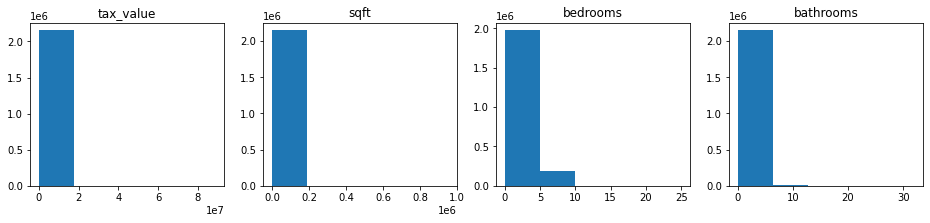

In [16]:
# Visualize the distributions of the features.
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in orig_draft_features.columns]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    orig_draft_features[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

#### Takeaways

* Significant square footage outliers exist.
* Similar outliers exist within the bedrooms and bathrooms columns.

<AxesSubplot:>

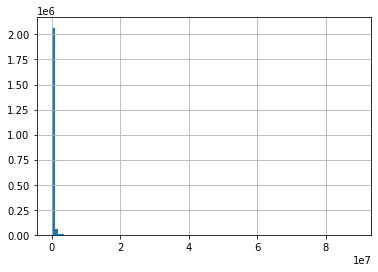

In [17]:
# Looking at tax_value in closer detail
orig_draft_features['tax_value'].hist(bins=100)

### Boxplots

Boxplots are useful because they will naturally show outliers as black diamonds on the diagram.

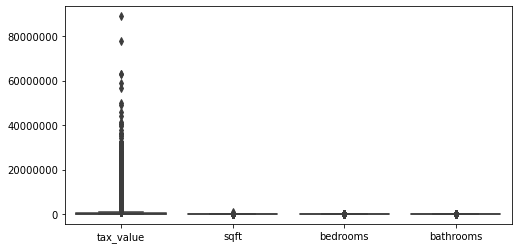

In [18]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=orig_draft_features)

plt.show()

### Takeaway

* The tax value has such a severe outlier problem, it is making the chart unreadable.

* I will try to make the charts bigger to see if visualization improves.

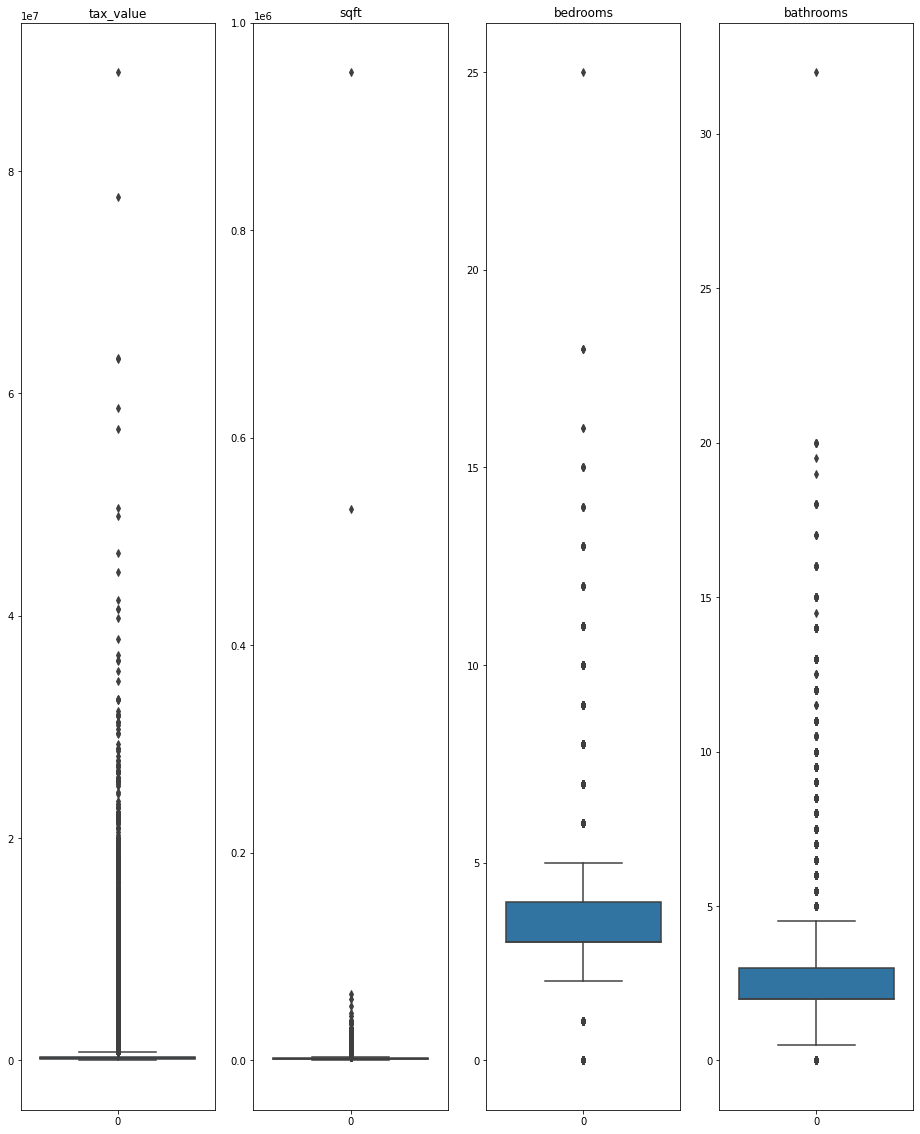

In [19]:
# List of columns
cols = [col for col in orig_draft_features.columns]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=orig_draft_features[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

What are the quartiles for these columns?

In [20]:
orig_draft_features.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,tax_value,sqft,bedrooms,bathrooms
count,2.15248e+06,2.1445e+06,2.15297e+06,2.15297e+06
mean,283714,1862.85,3.28719,2.23068
std,502669,1222.12,0.954791,0.999279
min,1,1,0,0
25%,79667.5,1257,3,2
50%,183894,1623,3,2
75%,345279,2208,4,3
max,8.8922e+07,952576,25,32


### Takeaways

* Too many outliers.
* The MVP will focus on home values closer to the median so it will be okay to remove high value homes.
* Removing these records may also help to reduce the amount of null values we have.

In [21]:
# This function removes outliers.
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [22]:
# Run the function and store results in a variable.
orig_draft_features = remove_outliers(orig_draft_features, 1.5, ['tax_value', 'sqft', 'bedrooms', 'bathrooms'])

### Revisualize Distributions

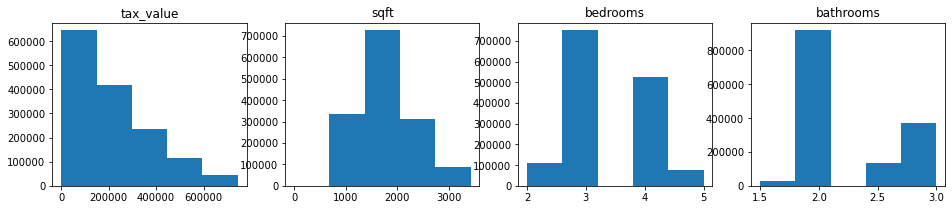

In [23]:
# After removing outliers replot the distributions.

plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in orig_draft_features.columns]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    orig_draft_features[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

### Takeaways

* Tax_value is right skewed.
* Bedrooms and bathrooms are not normally distributed.
* Square footage is approaching a normal distrubtion.

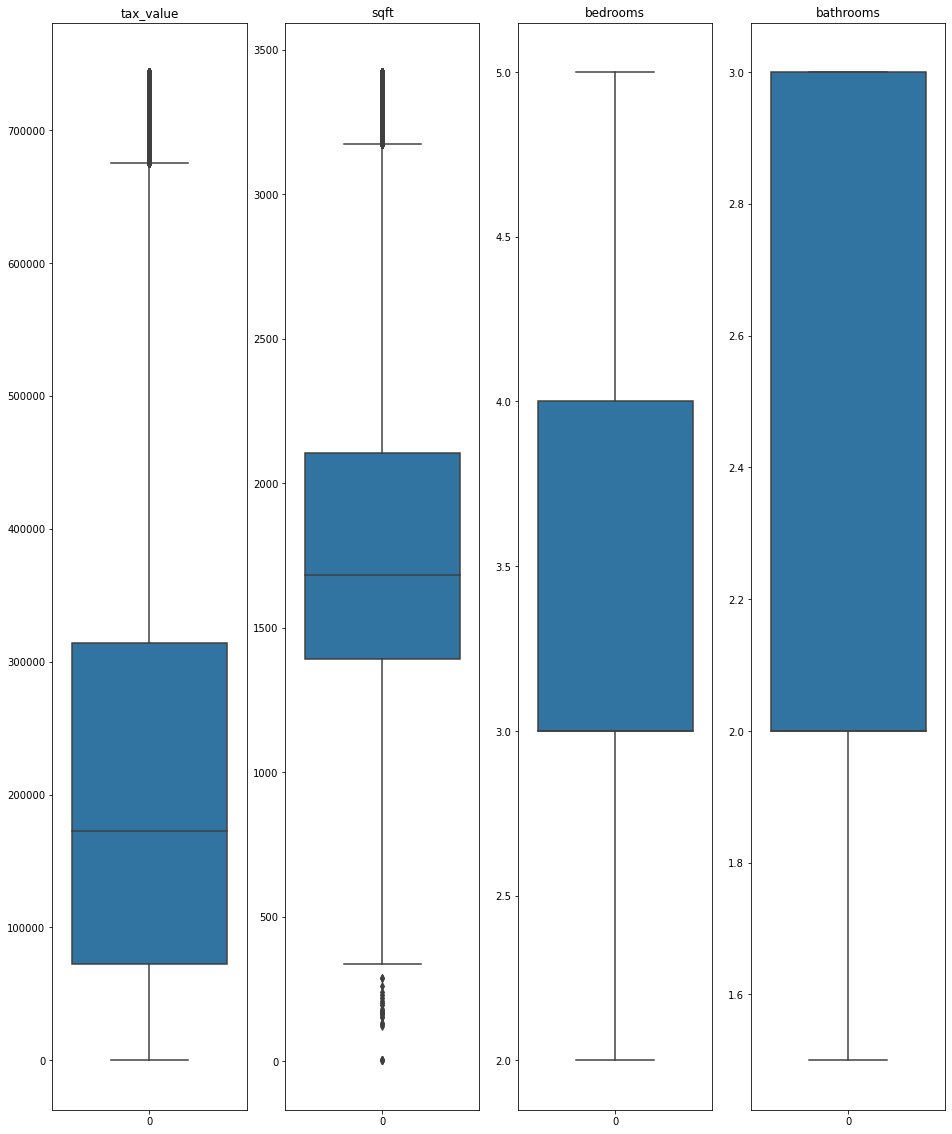

In [24]:
# View boxplots.
cols = [col for col in orig_draft_features.columns]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=orig_draft_features[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

### Takeaways

* Still a few outliers despite the relatively restrictive 1.5 * IQR setting for the upper/lower boundary.
* No need to remove these outliers.

### How do the null values look now?

In [25]:
orig_draft_features.isnull().sum()

tax_value    0
sqft         0
bedrooms     0
bathrooms    0
dtype: int64

### Are the column data types correct?

In [26]:
orig_draft_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459648 entries, 0 to 2152983
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   tax_value  1459648 non-null  float64
 1   sqft       1459648 non-null  float64
 2   bedrooms   1459648 non-null  float64
 3   bathrooms  1459648 non-null  float64
dtypes: float64(4)
memory usage: 55.7 MB


### Split the data

In [27]:
train_validate, test = train_test_split(orig_draft_features, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [28]:
train.info(), validate.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817402 entries, 457147 to 1912728
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   tax_value  817402 non-null  float64
 1   sqft       817402 non-null  float64
 2   bedrooms   817402 non-null  float64
 3   bathrooms  817402 non-null  float64
dtypes: float64(4)
memory usage: 31.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 350316 entries, 1035103 to 1219106
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   tax_value  350316 non-null  float64
 1   sqft       350316 non-null  float64
 2   bedrooms   350316 non-null  float64
 3   bathrooms  350316 non-null  float64
dtypes: float64(4)
memory usage: 13.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 291930 entries, 276690 to 1006044
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   ---

(None, None, None)

### Use the 'Min-Max Scaler' to scale the independent variables.

In [29]:
# 1. create the object
scaler = sklearn.preprocessing.MinMaxScaler()

# 2. fit the object (learn the min and max value)
scaler.fit(train[['sqft', 'bedrooms', 'bathrooms']])

# 3. use the object (use the min, max to do the transformation)
scaled_features = scaler.transform(train[['sqft', 'bedrooms', 'bathrooms']])

In [30]:
# assign the scaled values as new columns in the train
train[['sqft_scaled', 'bedrooms_scaled', 'bathrooms_scaled']] = scaled_features

In [31]:
train.head()

,tax_value,sqft,bedrooms,bathrooms,sqft_scaled,bedrooms_scaled,bathrooms_scaled
457147,32798.0,1746.0,3.0,2.0,0.509649,0.333333,0.333333
1920997,177850.0,1721.0,3.0,2.0,0.502339,0.333333,0.333333
164850,16522.0,1717.0,4.0,2.0,0.501170,0.666667,0.333333
476789,323127.0,1428.0,3.0,2.0,0.416667,0.333333,0.333333
684808,263808.0,2136.0,3.0,2.0,0.623684,0.333333,0.333333


In [32]:
validate.head()

,tax_value,sqft,bedrooms,bathrooms
1035103,366460.0,1709.0,3.0,2.0
87116,18000.0,1134.0,3.0,2.0
1908524,327120.0,2224.0,3.0,2.0
311138,52790.0,1663.0,4.0,2.0
1788615,68097.0,1527.0,4.0,3.0


In [33]:
# make new scaled columns for validate and test (transform only)

test[['sqft_scaled', 'bedrooms_scaled', 'bathrooms_scaled']] = scaler.transform(test[['sqft', 'bedrooms', 'bathrooms']])
validate[['sqft_scaled', 'bedrooms_scaled', 'bathrooms_scaled']] = scaler.transform(validate[['sqft', 'bedrooms', 'bathrooms']])

### Implementation

In [34]:
def add_scaled_columns(train, validate, test, scaler, columns_to_scale):
    
    # new column names
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    # Fit the scaler on the train
    scaler.fit(train[columns_to_scale])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return train, validate, test

### Can I predict the land tax value of a home based on square footage?

x = square footage
y = tax value

## Look at scatter of square footage vs tax value

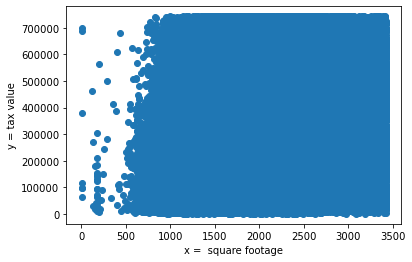

In [35]:
plt.scatter(orig_draft_features.sqft, orig_draft_features.tax_value)
plt.xlabel('x =  square footage')
plt.ylabel('y = tax value');

### Create a baseline prediction.

In [36]:
baseline = orig_draft_features.tax_value.mean()

In [37]:
# My baseline is the mean of tax_value
orig_draft_features['baseline'] = baseline

In [38]:
orig_draft_features.head()

,tax_value,sqft,bedrooms,bathrooms,baseline
0,17519.0,1848.0,4.0,2.0,212256.338282
1,274127.0,1430.0,2.0,2.0,212256.338282
2,160505.0,1572.0,3.0,2.0,212256.338282
3,54446.0,1412.0,3.0,2.0,212256.338282
4,385591.0,1352.0,3.0,2.0,212256.338282


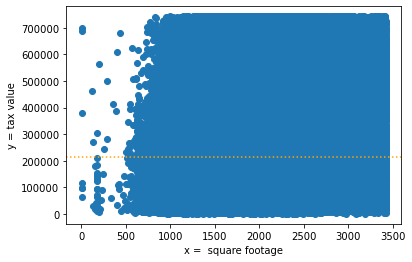

In [39]:
# plot data with baseline:

plt.scatter(orig_draft_features.sqft, orig_draft_features.tax_value)
plt.axhline(baseline, ls = ':', color='orange')
plt.xlabel('x =  square footage')
plt.ylabel('y = tax value');

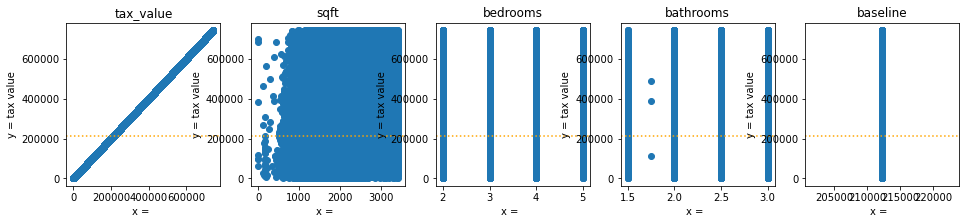

In [40]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in orig_draft_features.columns]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display scatterplot for column.
    plt.scatter(orig_draft_features[col], orig_draft_features.tax_value)
    plt.axhline(baseline, ls = ':', color='orange')
    plt.xlabel('x =  ')
    plt.ylabel('y = tax value');

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

In [41]:
target = "tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817402 entries, 457147 to 1912728
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sqft              817402 non-null  float64
 1   bedrooms          817402 non-null  float64
 2   bathrooms         817402 non-null  float64
 3   sqft_scaled       817402 non-null  float64
 4   bedrooms_scaled   817402 non-null  float64
 5   bathrooms_scaled  817402 non-null  float64
dtypes: float64(6)
memory usage: 43.7 MB


In [42]:
X_train_scaled = X_train.drop(columns=['sqft','bedrooms','bathrooms'])
X_validate_scaled = X_validate.drop(columns=['sqft','bedrooms','bathrooms'])
X_test_scaled = X_test.drop(columns=['sqft','bedrooms','bathrooms'])

In [43]:
X_test_scaled

,sqft_scaled,bedrooms_scaled,bathrooms_scaled
276690,0.539766,0.666667,0.333333
103956,0.753509,0.666667,1.000000
1961388,0.554971,0.666667,0.333333
1632933,0.504386,0.333333,0.333333
1791407,0.485088,0.666667,0.333333
...,...,...,...
1097509,0.280994,0.000000,0.333333
1172284,0.463743,0.333333,0.333333
1761130,0.442105,0.333333,0.333333
1268000,0.543567,0.000000,0.333333


In [44]:
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

def select_kbest(X, y, k):
    # make the object
    kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=k)

    # fit the object
    kbest.fit(X, y)
    
    # use the object (.get_support() is that array of booleans to filter the list of column names)
    return X.columns[kbest.get_support()].tolist()

In [46]:
# Find the top 2 features using kbest
select_kbest(X_train_scaled, y_train, 2)

['sqft_scaled', 'bathrooms_scaled']

In [47]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # rfe here is reference rfe from cell 15
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by="Rank", ascending=True)
    return ranks

In [48]:
# Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. 

def select_rfe(X, y, k):
    # make the thing
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=k)

    # Fit the thing
    rfe.fit(X, y)
    
    # use the thing
    features_to_use = X.columns[rfe.support_].tolist()
    
    # we need to send show_feature_rankings a trained/fit RFE object
    all_rankings = show_features_rankings(X, rfe)
    
    return features_to_use, all_rankings

In [49]:
select_rfe(X_train_scaled, y_train, 2)

(['sqft_scaled', 'bedrooms_scaled'],
                 Var  Rank
 0       sqft_scaled     1
 1   bedrooms_scaled     1
 2  bathrooms_scaled     2)

In [50]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [51]:
# 1. Predict tax_value mean
tax_value_mean = baseline
y_train['tax_value_mean'] = baseline
y_validate['tax_value_mean'] = baseline

In [52]:
# 2. compute tax_value median
tax_value_median = y_train.tax_value.median()
y_train['tax_value_median'] = tax_value_median
y_validate['tax_value_median'] = tax_value_median

In [53]:
# 3. RMSE of tax_value_mean
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.tax_value_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_mean) ** (0.5)

In [54]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  167162.43 
Validate/Out-of-Sample:  167387.77


In [90]:
# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_median) ** (0.5)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  171862.64 
Validate/Out-of-Sample:  172026.37


### Build a dataframe for comparison of our metrics for model selection for ease of reflection.


In [56]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [57]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,167162.430722,167387.767193


In [58]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817402 entries, 457147 to 1912728
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tax_value         817402 non-null  float64
 1   tax_value_mean    817402 non-null  float64
 2   tax_value_median  817402 non-null  float64
dtypes: float64(3)
memory usage: 24.9 MB


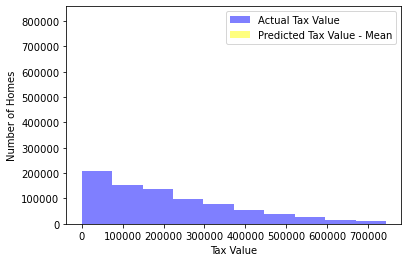

In [91]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.tax_value_mean, color='yellow', alpha=.5, label="Predicted Tax Value - Mean")
# plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, label="Predicted Final Grades - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

### LinearRegression (OLS)

Fit the model using X_train (scaled) and the labels from y_train.

Predict tax value for homes in training sample using our model (lm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [60]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817402 entries, 457147 to 1912728
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sqft_scaled       817402 non-null  float64
 1   bedrooms_scaled   817402 non-null  float64
 2   bathrooms_scaled  817402 non-null  float64
dtypes: float64(3)
memory usage: 24.9 MB


In [61]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817402 entries, 457147 to 1912728
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tax_value         817402 non-null  float64
 1   tax_value_mean    817402 non-null  float64
 2   tax_value_median  817402 non-null  float64
dtypes: float64(3)
memory usage: 24.9 MB


In [62]:
# create the model object

# make the thing

lm = LinearRegression()

In [63]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train_scaled, y_train.tax_value)

LinearRegression()

In [64]:
# predict train
# 
# use the thing!
# 
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

In [65]:
y_train.head()

,tax_value,tax_value_mean,tax_value_median,tax_value_pred_lm
457147,32798.0,212256.338282,172382.0,216752.210761
1920997,177850.0,212256.338282,172382.0,214858.723632
164850,16522.0,212256.338282,172382.0,191776.350460
476789,323127.0,212256.338282,172382.0,192667.054480
684808,263808.0,212256.338282,172382.0,246290.609973


In [66]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  163271.41242134752 
Validation/Out-of-Sample:  163511.516044357


In [67]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [68]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,167162.430722,167387.767193
1,OLS Regressor,163271.412421,163511.516044


### LassoLars

Fit the model using X_train (scaled) and the labels from y_train.

Predict tax value for homes in training sample using our model (lars).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [69]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  163281.48963920702 
Validation/Out-of-Sample:  163521.78278414372 
Difference:  240.29314493670245


In [70]:
lars.coef_

array([251418.26752431, -61027.51527059,   2805.62685605])

In [71]:
metric_df = metric_df.append({
    'model': 'lasso_alpha0.1', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [72]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,167162.430722,167387.767193
1,OLS Regressor,163271.412421,163511.516044
2,lasso_alpha0.1,163281.489639,163521.782784


### TweedieRegressor (GLM)

Fit the model using X_train (scaled) and the labels from y_train.

Predict tax value for homes in training sample using our model (glm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [73]:
from sklearn.linear_model import TweedieRegressor

<AxesSubplot:>

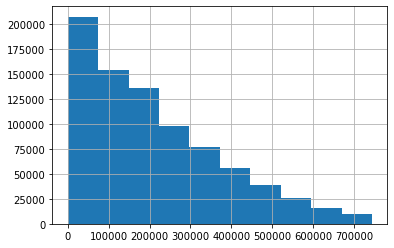

In [74]:
y_train.tax_value.hist()

In [75]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  163331.77940483554 
Validation/Out-of-Sample:  163580.1776509355


In [76]:
metric_df = metric_df.append({
    'model': 'glm_poisson', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [77]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,167162.430722,167387.767193
1,OLS Regressor,163271.412421,163511.516044
2,lasso_alpha0.1,163281.489639,163521.782784
3,glm_poisson,163331.779405,163580.177651


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

Create the new features, based on value indicated for degree for train, validate & test.

Fit the Linear Regression model

Predict using the transformed (squared or cubed, e.g.) features

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [78]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)

In [79]:
X_train_degree2.shape

(817402, 10)

### LinearRegression

In [80]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  163157.13568499978 
Validation/Out-of-Sample:  163406.10491334615


In [81]:
metric_df = metric_df.append({
    'model': 'quadratic', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [82]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,167162.430722,167387.767193
1,OLS Regressor,163271.412421,163511.516044
2,lasso_alpha0.1,163281.489639,163521.782784
3,glm_poisson,163331.779405,163580.177651
4,quadratic,163157.135685,163406.104913


### Evaluate

#### Plotting Actual vs. Predicted Values

In [83]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 230000))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (10, 20000), rotation=26)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

AttributeError: 'DataFrame' object has no attribute 'tax_value_pred_mean'

<Figure size 1152x576 with 0 Axes>

### Takeaways

* The Linear Regression model is good at predicting tax values from the 100,000 to 350,000 range.
* The two other models have similar predictions.

#### Residual Plots: Plotting the Errors in Predictions

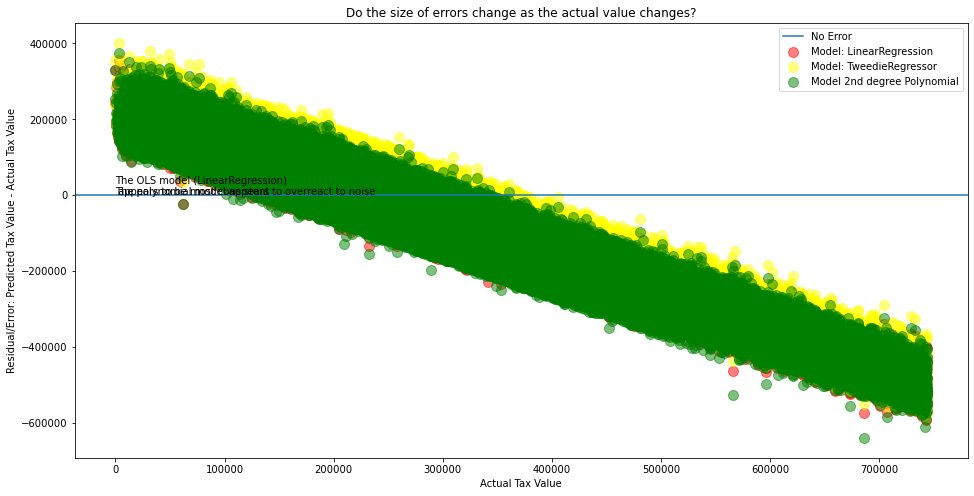

In [84]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Takeaway
* My models get a better prediction from the 150,000 to 300,000 range.
* These models overvalues cheaper homes and undervalues more expensive homes.

### Histograms

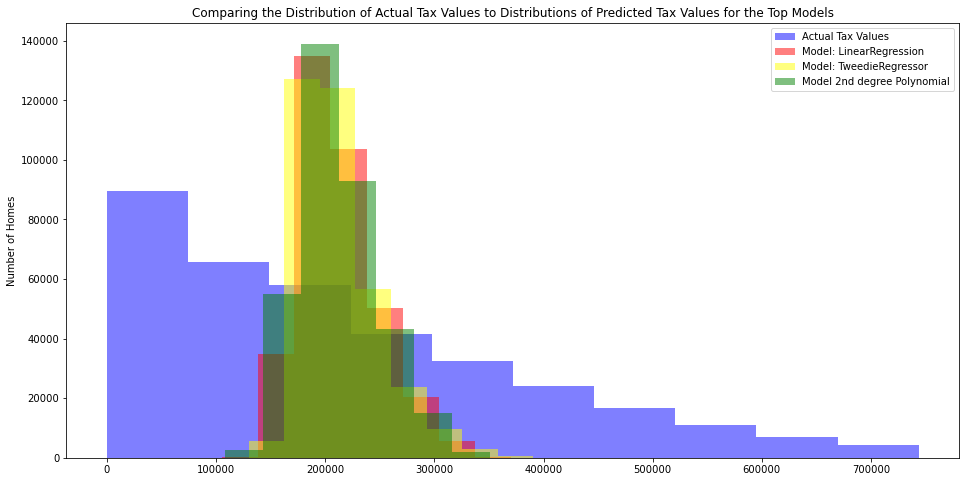

In [85]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
# plt.xlabel("Tax Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

### Takeaways

* The models predict tax values from the 100000 to the 400000 range.
* The models are overpredicting the amount of 200000-250000 dollar homes.

### Going with the OLS model to use on the test set.

In [86]:
# predict test
# 
# use the thing!
# 
y_test_predictions = lm.predict(X_test_scaled)

In [87]:
# evaluate: rmse
rmse_test = mean_squared_error(y_test, y_test_predictions) ** (1/2)

In [89]:
rmse_test

163232.60581145086

In [92]:
metric_df = metric_df.append({
    'model': 'Best Model(OLS)', 
    'RMSE_test': rmse_test
    }, ignore_index=True)

In [93]:
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test
0,mean_baseline,167162.430722,167387.767193,NaN
1,OLS Regressor,163271.412421,163511.516044,NaN
2,lasso_alpha0.1,163281.489639,163521.782784,NaN
3,glm_poisson,163331.779405,163580.177651,NaN
4,quadratic,163157.135685,163406.104913,NaN
5,Best Model(OLS),NaN,NaN,163232.605811
